In [1]:
import sys
sys.path.append("/data1/andrew/meng/mixehr/meng/VAE-EHR/src")
import os
print(sys.version)

from vae import VAE, VAETrainer
from config_reader import Config
from icd_analysis_helper import ICDAnalysisHelper
from visualizer_helper import Visualizer
#from patient_cluster import PatientCluster

from typing import List, Tuple
import numpy as np 
import pandas as pd
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

import hdbscan
from wordcloud import WordCloud
import collections

import pickle

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
config = Config(config_file_path='./config.ini', date='200113')
config.__dict__

{'patient_icd_path': '/data1/andrew/meng/mixehr/data/Mimic/andrew_outputs/PATIENT_ICD_BINARY.csv',
 'icd9codes_path': '/data1/andrew/meng/mixehr/data/Mimic/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz',
 'experiment_name': '200113_patient_clusters_25_latent_dim_beta_vae',
 'encoder_dim': [(250, 500), (500, 250), (250, 100)],
 'latent_dim': 25,
 'decoder_dim': [],
 'use_relu': True,
 'kld_beta': 5.0}

In [3]:
patient_icd_df=pd.read_csv(config.patient_icd_path, sep=' ')
patient_icd_data = patient_icd_df.drop('SUBJECT_ID', axis=1)
data = torch.tensor(patient_icd_data.values).float()
print(data.shape)

torch.Size([46520, 6984])


In [4]:
icd9codes = pd.read_csv(config.icd9codes_path)
icd_analyzer = ICDAnalysisHelper(icd9codes_df = icd9codes, patient_icd_df = patient_icd_df)

visualizer = Visualizer()

In [5]:
print("Feature_dim: {}".format(data.shape[1]))
model = VAE(
    feature_dim = data.shape[1], 
    encoder_dim = config.encoder_dim,
    latent_dim = config.latent_dim,
    decoder_dim = config.decoder_dim,
    use_relu= config.use_relu
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(type(optimizer))

experiment_name=config.experiment_name
epoch = 55
model.load_state_dict(torch.load("./VAE_exp_{}_epoch_{}.pkl".format(experiment_name, epoch)))

trainer = VAETrainer(
    model=model, 
    optimizer=optimizer,
    experiment_name=experiment_name,
    kld_beta=config.kld_beta
)

Feature_dim: 6984
<class 'torch.optim.adam.Adam'>


In [6]:
latent, means, var = trainer.encode_data(data)

In [ ]:
latent_clustering = pickle.load( open('hdbscan_latent_clusters.p', 'rb'))
latent_clustering

In [ ]:
pickle.dump(latent_clustering, open("hdbscan_latent_clusters.p", "wb"))

In [7]:
hdbscanner = hdbscan.HDBSCAN()
latent_clustering = hdbscanner.fit_predict(latent.cpu().detach().numpy())

In [8]:
patient_icd_df_with_cluster_assignments = patient_icd_df.assign(CLUSTER=latent_clustering)
patient_icd_df_with_cluster_assignments

,SUBJECT_ID,0030,0031,0038,0039,0041,0048,0049,0051,00581,...,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103,CLUSTER
0,109,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,113,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,114,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
5,116,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,220
6,117,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7,118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,224
8,119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,120,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,227


In [9]:
class PatientCluster:
    def __init__(self, 
                patient_icd_df_with_cluster_assignments, 
                cluster):
        self.cluster = cluster
        self.cluster_df = patient_icd_df_with_cluster_assignments[patient_icd_df_with_cluster_assignments.CLUSTER == cluster]
        
        self.disease_df = self.cluster_df.drop(['SUBJECT_ID', 'CLUSTER'], axis=1)
        self.disease_distribution = self.disease_df.sum(axis=0).sort_values(ascending=False)
        
    def get_cluster_ids(self):
        return self.cluster_df.SUBJECT_ID

    def plot_disease_distribution(self, top_k_diseases: int=10, use_short_titles: bool=True):
        
        disease_distribution = self.disease_distribution[:top_k_diseases].sort_values(ascending=True)
        plt.figure(figsize=(5, 10))
        plt.barh(np.arange(disease_distribution.size),
           disease_distribution.to_numpy(),
           align='center')
        
        if use_short_titles:
            title_keys = map(lambda icd9code: ICDAnalysisHelper.get_icd_short_titles([icd9code]), 
                                disease_distribution.keys() )
        else:
            title_keys = map(lambda icd9code: ICDAnalysisHelper.get_icd_long_titles([icd9code]), 
                                disease_distribution.keys() )
        plt.yticks(np.arange(disease_distribution.size), title_keys)
        plt.xlim(0, np.max(disease_distribution))
        plt.show()

    def generate_wordcloud(self,
                           use_short_titles:bool=False,
                           weight_by_disease_frequency:bool=True,
                           max_words_in_cloud=200):
        ###Titles
        disease_freqs = self.disease_distribution.values
        
        if use_short_titles:
            titles = map(lambda icd9code: ICDAnalysisHelper.get_icd_short_titles([icd9code]),self.disease_distribution.index )
        else:
            titles = map(lambda icd9code: ICDAnalysisHelper.get_icd_long_titles([icd9code]),self.disease_distribution.index )
        
        ###Title Word Frequencies
        text_processor = WordCloud()
        all_word_freqs = collections.Counter()
        for i, title in enumerate(titles):
            title_word_counts = text_processor.process_text(title)
            
            #Reset all word counts to 1. This is in case the long title has multiple occurences of the same word
            title_word_counts.update((word, 1) for word in title_word_counts.keys())
            
            #Weight word by number of occurences in cluster
            if weight_by_disease_frequency:
                title_word_counts.update((word, disease_freqs[i]*count) for word, count in title_word_counts.items())
            
            all_word_freqs.update(title_word_counts)
                
        cloud = WordCloud(max_words=max_words_in_cloud, 
                          background_color="white",
                          colormap="cool").generate_from_frequencies(all_word_freqs)
        
        plt.figure(figsize=(10, 10))
        plt.title("WordCloud for Patient Cluster {}".format(self.cluster))
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        

In [10]:
cluster_neg_1 = PatientCluster(patient_icd_df_with_cluster_assignments, 1)
#cluster_neg_1.plot_disease_distribution(top_k_diseases=20, use_short_titles=False)

No long title found for ICD code ['9708']
No long title found for ICD code ['9697']
No long title found for ICD code ['4538']
No long title found for ICD code ['4582']
No long title found for ICD code ['4440']
No long title found for ICD code ['5185']
No long title found for ICD code ['5191']
No long title found for ICD code ['5128']
No long title found for ICD code ['5163']
No long title found for ICD code ['5233']
No long title found for ICD code ['5234']
No long title found for ICD code ['5118']
No long title found for ICD code ['4781']
No long title found for ICD code ['4881']
No long title found for ICD code ['4251']
No long title found for ICD code ['5280']
No long title found for ICD code ['6002']
No long title found for ICD code ['6082']
No long title found for ICD code ['6118']
No long title found for ICD code ['6213']
No long title found for ICD code ['6221']
No long title found for ICD code ['6188']
No long title found for ICD code ['6168']
No long title found for ICD code [

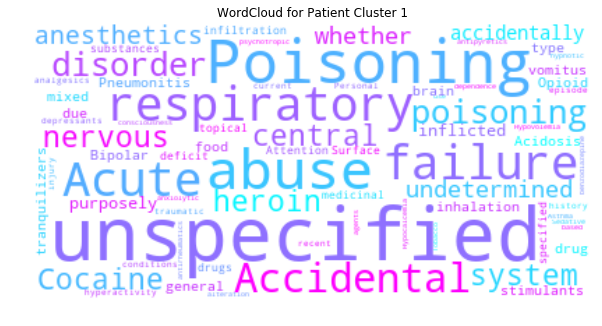

In [11]:
cluster_neg_1.generate_wordcloud(use_short_titles=False)

In [ ]:
ICDAnalysisHelper.lookup_icds(['7955'])